In [1]:
import os
%cd datasets
!bash get_datasets.sh
%cd ..

/Users/letunglam/Projects/deep-learning-training/minigrad/datasets
/Users/letunglam/Projects/deep-learning-training/minigrad


In [22]:
# setup cell
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers.fc_net import *
from data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (4900, 3, 32, 32)
y_train: (4900,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [15]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



In [23]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


In [29]:
np.random.seed(42)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print("Runinng check with dropout = ", dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2], input_dim = D, num_classes=C,
        weight_scale=5e-2, dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Runinng check with dropout =  1
Initial loss:  2.309647806660724
b3 relative error: 1.48e-10

Runinng check with dropout =  0.75
Initial loss:  2.3050629386125046
b3 relative error: 1.57e-10

Runinng check with dropout =  0.5
Initial loss:  2.2902949529325456
b3 relative error: 1.12e-10



In [39]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
numm_train = 500
small_data = {
    'X_train': data['X_train'][:numm_train],
    'y_train': data['y_train'][:numm_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500], dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model, small_data, num_epochs=25,
        batch_size=100, update_rule='adamw',
        optim_config={'learning_rate': 5e-4,},
        verbose = True, print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 7.833953
(Epoch 0 / 25) train acc: 0.268000; val acc: 0.179000
(Epoch 1 / 25) train acc: 0.408000; val acc: 0.230000
(Epoch 2 / 25) train acc: 0.470000; val acc: 0.257000
(Epoch 3 / 25) train acc: 0.550000; val acc: 0.264000
(Epoch 4 / 25) train acc: 0.622000; val acc: 0.259000
(Epoch 5 / 25) train acc: 0.712000; val acc: 0.301000
(Epoch 6 / 25) train acc: 0.762000; val acc: 0.288000
(Epoch 7 / 25) train acc: 0.804000; val acc: 0.300000
(Epoch 8 / 25) train acc: 0.848000; val acc: 0.284000
(Epoch 9 / 25) train acc: 0.874000; val acc: 0.284000
(Epoch 10 / 25) train acc: 0.912000; val acc: 0.272000
(Epoch 11 / 25) train acc: 0.902000; val acc: 0.292000
(Epoch 12 / 25) train acc: 0.932000; val acc: 0.297000
(Epoch 13 / 25) train acc: 0.976000; val acc: 0.291000
(Epoch 14 / 25) train acc: 0.986000; val acc: 0.293000
(Epoch 15 / 25) train acc: 0.984000; val acc: 0.284000
(Epoch 16 / 25) train acc: 0.986000; val acc: 0.305000
(Epoch 17 / 25) train acc: 0.990000; v

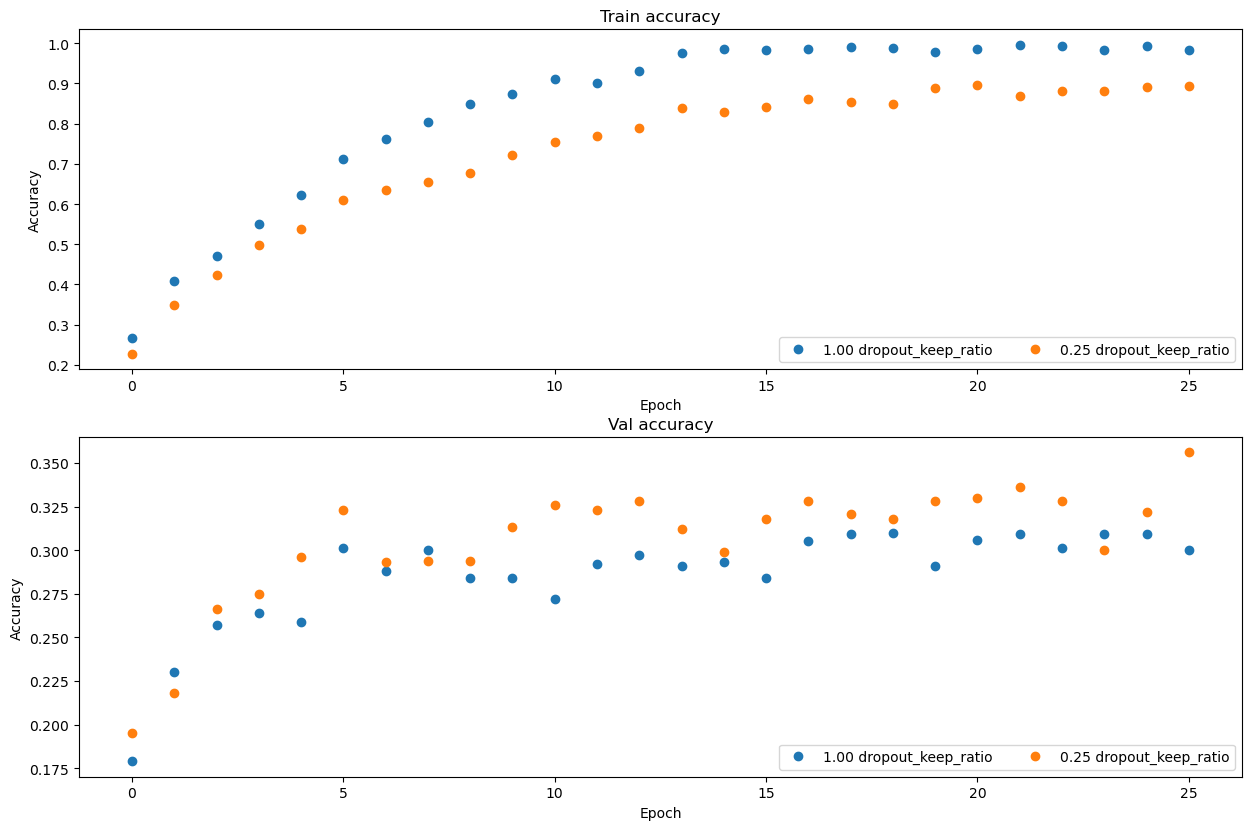

In [40]:
# Plot train and validation accuracies of the two model.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' %dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()